In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
from functions import *

In [102]:
nodes

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.0,0.0,NaN,NaN
1,10,0,NaN,NaN,0.0,-100.0
2,20,0,0.0,0.0,NaN,NaN
3,5,10,NaN,NaN,0.0,0.0
4,15,10,NaN,NaN,0.0,0.0


In [103]:
elements

,start_node,end_node,area,Youngs_modulus,density,length,stiffness_matrix,mass_matrix
0,0,1,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
1,1,2,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
2,0,3,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
3,1,3,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
4,1,4,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
5,4,2,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
6,3,4,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."


In [104]:
elements[['length', 'stiffness_matrix']] = elements.apply(element_stiffness, axis=1, result_type='expand')
elements['mass_matrix'] = elements.apply(element_mass, axis=1)
elements

,start_node,end_node,area,Youngs_modulus,density,length,stiffness_matrix,mass_matrix
0,0,1,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
1,1,2,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
2,0,3,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
3,1,3,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
4,1,4,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
5,4,2,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
6,3,4,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."


In [105]:
K = elements.apply(global_stiffness, axis=1).sum()
M = elements.apply(global_mass, axis=1).sum()

In [106]:
U = nodes[['displacement_x', 'displacement_y']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load_x', 'load_y']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition(K, A, B)
MAA, MAB, MBA, MBB = partition(M, A, B)

In [107]:
UB = U[B]
PA = P[A]
UA = np.dot(np.linalg.inv(KAA),(PA-np.dot(KAB,UB)))
U[A] = UA
PB = np.dot(KBA,UA)+np.dot(KBB,UB)
P[B] = PB

result = nodes.copy()
result[['displacement_x', 'displacement_y']] = U.reshape(-1,2)
result[['load_x', 'load_y']] = P.reshape(-1,2)
result

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.000000e+00,0.000000,25.0,50.0
1,10,0,3.517113e-19,-0.082377,0.0,-100.0
2,20,0,0.000000e+00,0.000000,-25.0,50.0
3,5,10,1.250000e-02,-0.041189,0.0,0.0
4,15,10,-1.250000e-02,-0.041189,0.0,0.0


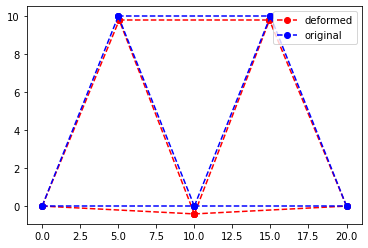

In [108]:
factor = 5
result['deformed_x'] = result['coordinate_x'] + factor*result['displacement_x']
result['deformed_y'] = result['coordinate_y'] + factor*result['displacement_y']

connectpoints(result['deformed_x'], result['deformed_y'],0,1,True,True)
connectpoints(result['deformed_x'], result['deformed_y'],1,2)
connectpoints(result['deformed_x'], result['deformed_y'],0,3)
connectpoints(result['deformed_x'], result['deformed_y'],1,3)
connectpoints(result['deformed_x'], result['deformed_y'],1,4)
connectpoints(result['deformed_x'], result['deformed_y'],2,4)
connectpoints(result['deformed_x'], result['deformed_y'],3,4)

connectpoints(result['coordinate_x'], result['coordinate_y'],0,1,False,True)
connectpoints(result['coordinate_x'], result['coordinate_y'],1,2,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],0,3,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],1,3,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],1,4,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],2,4,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],3,4,False)

plt.legend()
plt.show()

In [109]:
frequencies, modes = modal_analysis(MAA, KAA)

In [110]:
deltaT = 0.001
T = 1000

a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = -np.dot(np.dot(np.linalg.inv(MAA), KAA), a)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)

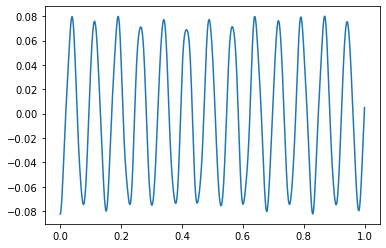

In [111]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:])
plt.show()

In [112]:
dt = 0.001
t = 1000

d = np.zeros((len(UA),1))
d[:,0] = np.transpose(UA)
d_dot = np.zeros((len(UA),1))
v = np.zeros((len(UA),1))
v_dot = -np.dot(np.dot(np.linalg.inv(MAA), KAA), d)

d, d_dot, v, v_dot = Alpha(MAA, KAA, d, d_dot, v, v_dot, dt, t)

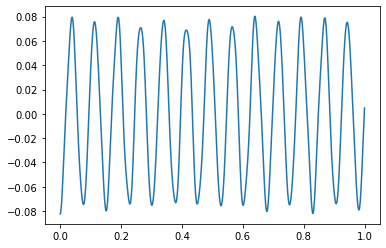

In [113]:
plt.plot(np.linspace(0, t*dt, t), d[1,:])
plt.show()

In [114]:
T_range = [0,1]
x_0 = np.transpose(np.hstack((UA,np.zeros(len(UA)))))
time, x = Runge_Kutta(MAA, KAA, T_range, x_0)

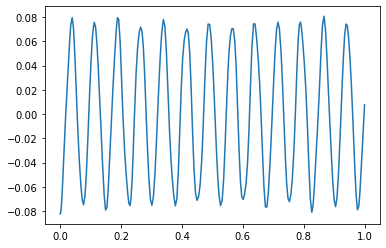

In [115]:
plt.plot(time, x[1,:])
plt.show()

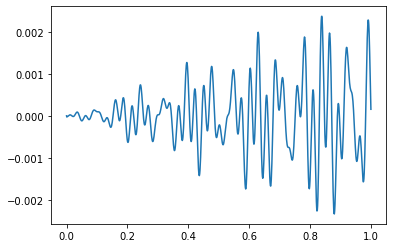

In [116]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:]-d[1,:])

In [117]:
CAA, damping_factors = damping_factors(frequencies, frequencies[0], frequencies[1], 0.1, 0.1, MAA, KAA)

In [118]:
deltaT = 0.001
T = 1000

a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), -np.dot(CAA, a_dot)-np.dot(KAA, a))
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a, a_dot, a_ddot = Newmark_Beta_damping(MAA, CAA, KAA, f, a, a_dot, a_ddot, deltaT, T)

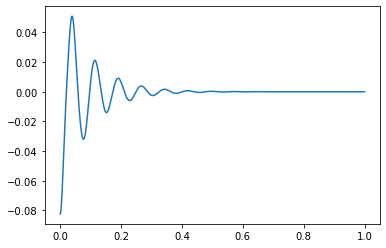

In [119]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:])
plt.show()

In [120]:
dt = 0.001
t = 1000

d = np.zeros((len(UA),1))
d[:,0] = np.transpose(UA)
d_dot = np.zeros((len(UA),1))
v = np.zeros((len(UA),1))
v_dot = np.dot(np.linalg.inv(MAA), -np.dot(CAA, d_dot)-np.dot(KAA, d))

d, d_dot, v, v_dot = Alpha_damping(MAA, CAA, KAA, d, d_dot, v, v_dot, dt, t)

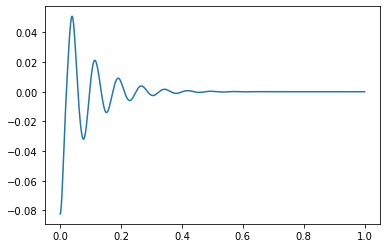

In [121]:
plt.plot(np.linspace(0, t*dt, t), d[1,:])
plt.show()

In [122]:
T_range = [0,1]
x_0 = np.transpose(np.hstack((UA,np.zeros(len(UA)))))
time, x = Runge_Kutta_damping(MAA, CAA, KAA, T_range, x_0)

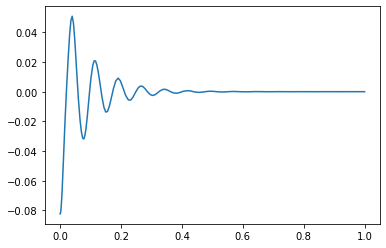

In [123]:
plt.plot(time, x[1,:])
plt.show()

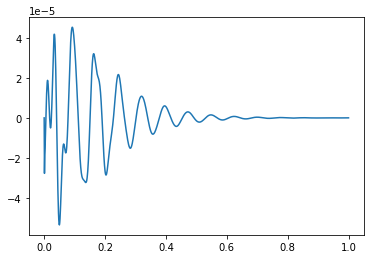

In [124]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:]-d[1,:])

In [125]:
A = transition_matrix_Newmark_Beta(MAA, KAA, deltaT)
B = force_matrix_Newmark_Beta(MAA, KAA, deltaT)

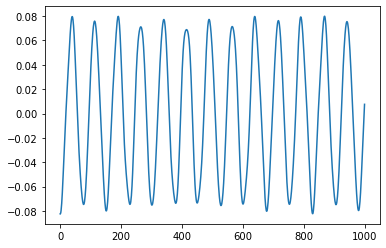

In [126]:
a = np.zeros((3*len(UA),1))
a[0:6,0] = np.transpose(UA)
for i in range(T):
  a_new = np.dot(A, a[:,i])
  a = np.append(a, a_new.reshape(3*len(UA),1), axis=1)

plt.plot(a[1,:])

In [127]:
deltaT = 0.001
T = 1000

a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = -np.dot(np.dot(np.linalg.inv(MAA), KAA), a)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)

In [128]:
data = generate_pseudo_data(a, T, 0.1)

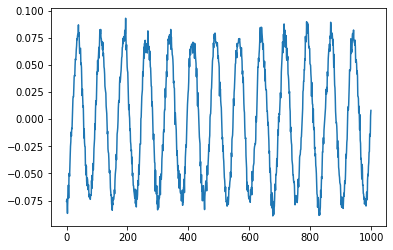

In [129]:
plt.plot(data[1,:])

In [130]:
H = observe_displacements(A)

In [131]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)
x, energy = Kalman_filter(A, B, H, x, f, data, 1, 1, 1, T)

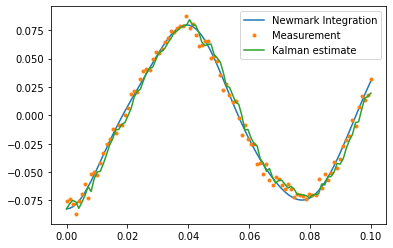

In [132]:
scale = 0.1
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a[1,:int(T*scale)], label='Newmark Integration')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), data[1,:int(T*scale)], '.', label='Measurement')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), x[1,:int(T*scale)], label='Kalman estimate')

plt.legend()
plt.show()

In [133]:
elements2[['length', 'stiffness_matrix']] = elements2.apply(element_stiffness, axis=1, result_type='expand')
elements2['mass_matrix'] = elements2.apply(element_mass, axis=1)
elements2

,start_node,end_node,area,Youngs_modulus,density,length,stiffness_matrix,mass_matrix
0,0,1,0.000002,1.000000e+10,3500,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.034999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
1,1,2,0.000002,1.000000e+10,3500,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.034999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
2,0,3,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
3,1,3,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
4,1,4,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
5,4,2,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
6,3,4,0.000002,1.000000e+10,3500,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.034999999999999996, 0.0, 0.0, 0.0], [0.0, ..."


In [134]:
K2 = elements2.apply(global_stiffness, axis=1).sum()
M2 = elements2.apply(global_mass, axis=1).sum()

In [135]:
U = nodes[['displacement_x', 'displacement_y']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load_x', 'load_y']].to_numpy()
P = P.ravel()
B = np.isnan(P)
KAA2, KAB2, KBA2, KBB2 = partition(K2, A, B)
MAA2, MAB2, MBA2, MBB2 = partition(M2, A, B)
UB = U[B]
PA = P[A]
UA = np.dot(np.linalg.inv(KAA2),(PA-np.dot(KAB2,UB)))
U[A] = UA
PB = np.dot(KBA2,UA)+np.dot(KBB2,UB)
P[B] = PB

In [136]:
A = transition_matrix_Newmark_Beta(MAA, KAA, deltaT)
A2 = transition_matrix_Newmark_Beta(MAA2, KAA2, deltaT)
B = force_matrix_Newmark_Beta(MAA, KAA, deltaT)
B2 = force_matrix_Newmark_Beta(MAA2, KAA2, deltaT)

In [137]:
a2 = np.zeros((len(UA),1))
a2[:,0] = np.transpose(UA)
a2_dot = np.zeros((len(UA),1))
a2_ddot = np.dot(np.linalg.inv(MAA2), np.dot(KAA2, a2))
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a2, a2_dot, a2_ddot = Newmark_Beta(MAA2, KAA2, f, a2, a2_dot, a2_ddot, deltaT, T)
data2 = generate_pseudo_data(a2, T, 0.1)

In [138]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)
x, energy = Kalman_filter(A, B, H, x, f, data2, 0.1, 0.1, 0.1, T)

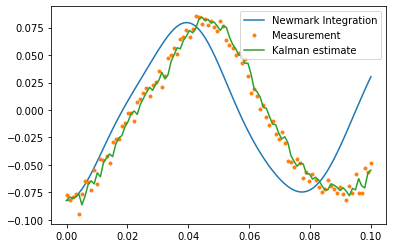

In [139]:
scale = 0.1
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a[1,:int(T*scale)], label='Newmark Integration')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), data2[1,:int(T*scale)], '.', label='Measurement')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), x[1,:int(T*scale)], label='Kalman estimate')

plt.legend()
plt.show()

In [140]:
def random_force(param, T):
  return np.tile(np.array(np.random.normal(param,40, (6,1))), (1,T))

[[ -78.49198271  -78.49198271  -78.49198271 ...  -78.49198271
   -78.49198271  -78.49198271]
 [-139.1567207  -139.1567207  -139.1567207  ... -139.1567207
  -139.1567207  -139.1567207 ]
 [ -98.86520717  -98.86520717  -98.86520717 ...  -98.86520717
   -98.86520717  -98.86520717]
 [-170.41117692 -170.41117692 -170.41117692 ... -170.41117692
  -170.41117692 -170.41117692]
 [ -39.58207118  -39.58207118  -39.58207118 ...  -39.58207118
   -39.58207118  -39.58207118]
 [-117.60612443 -117.60612443 -117.60612443 ... -117.60612443
  -117.60612443 -117.60612443]]


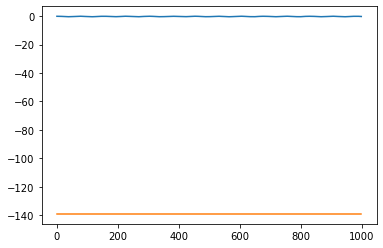

In [141]:
f = random_force(-100, T)
# f = np.random.normal(-100,10, (len(PA),T))
print(f)
a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), -np.dot(CAA, a_dot)-np.dot(KAA, a))
a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
plt.plot(a[1,:])
plt.plot(f[1,:])

In [142]:
data = generate_pseudo_data(a, T, 0.1)

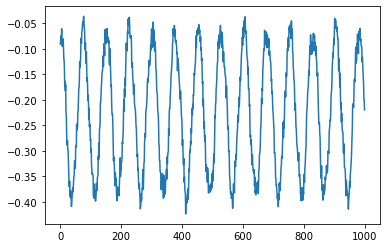

In [143]:
plt.plot(data[1,:])

-63.520911077238175


(array([ 1.,  0.,  0., 14.,  1.,  1.,  3.,  0.,  0.,  1.,  0.,  0., 13.,
         0.,  0.,  0.,  4., 17.,  2.,  0., 16.,  0.,  3.,  0.,  0.,  0.,
         0.,  0.,  0., 24.]),
 array([-76.1013943 , -75.68204486, -75.26269542, -74.84334598,
        -74.42399654, -74.0046471 , -73.58529766, -73.16594822,
        -72.74659877, -72.32724933, -71.90789989, -71.48855045,
        -71.06920101, -70.64985157, -70.23050213, -69.81115269,
        -69.39180325, -68.97245381, -68.55310437, -68.13375493,
        -67.71440548, -67.29505604, -66.8757066 , -66.45635716,
        -66.03700772, -65.61765828, -65.19830884, -64.7789594 ,
        -64.35960996, -63.94026052, -63.52091108]),
 <BarContainer object of 30 artists>)

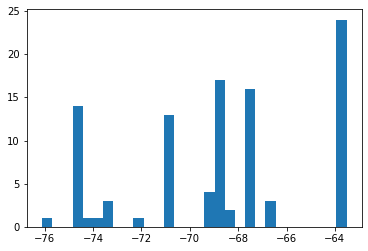

In [144]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
param, energy_list, X = Metropolis_Hasting(A, B, H, x, random_force, data, 1, 1, 1, -80, 10, 5, T, 100)
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
plt.hist(param, bins=30)

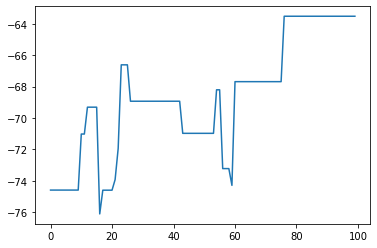

In [145]:
plt.plot(param)

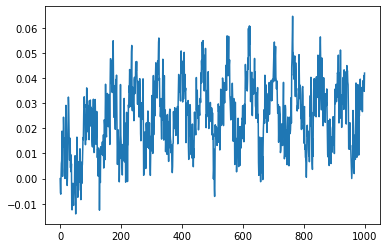

In [146]:
plt.plot(X[index][1,:]-a[1,:])

In [147]:
diff = 0
for i in range(len(a[1,:])):
    diff += (X[index][1,i]-a[1,i])**2
print(diff)

0.8039281938017935
